In [7]:
import zipfile
import os

zip_path = '/content/archive(3).zip'  # Corrected filename
extract_path = '/content/data'

os.makedirs(extract_path, exist_ok=True)

if os.path.exists(zip_path):
  try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset unzipped successfully!")
  except zipfile.BadZipFile:
    print("Error: The file is not a valid zip file.")
else:
  print("Error: zip file not found.")

# Verify the extracted data
print(os.listdir('/content/data')) #list the contents of the data directory.

Dataset unzipped successfully!
['Data']


In [8]:
import zipfile
import os

zip_path = '/content/archive(3).zip' #replace your_dataset.zip
extract_path = '/content/data'

os.makedirs(extract_path, exist_ok=True) #make data directory

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully!")

Dataset unzipped successfully!


In [9]:
!pip install tensorflow scikit-learn numpy pandas matplotlib opencv-python scikit-image

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import resnet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Flatten, Reshape, Conv2D

def load_and_preprocess_data(data_dir, target_size=(224, 224)):
    images = []
    labels = []
    label_map = {'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'small.cell.carcinoma': 3}

    for label_name, label_id in label_map.items():
        label_dir = os.path.join(data_dir, label_name)
        if os.path.exists(label_dir):
            for filename in os.listdir(label_dir):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(label_dir, filename)
                    img = load_img(img_path, target_size=target_size)
                    img_array = img_to_array(img)
                    img_array = resnet50.preprocess_input(img_array)
                    images.append(img_array)
                    labels.append(label_id)
        else:
            print(f"Warning: Directory {label_dir} not found.")

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

def split_data(images, labels, test_size=0.2, val_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, stratify=labels)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size / (1 - test_size), stratify=y_train)
    return X_train, X_val, X_test, y_train, y_val, y_test

def create_hybrid_model(input_shape, num_classes):
    base_cnn = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_cnn.trainable = False

    inputs = Input(shape=input_shape)
    x = base_cnn(inputs)

    x = Conv2D(256, 1, padding='same', activation='relu')(x)
    x = Reshape((-1, 256))(x)

    attention_output = MultiHeadAttention(num_heads=8, key_dim=256)(x, x)
    x = Add()([x, attention_output])
    x = LayerNormalization()(x)

    x = GlobalAveragePooling2D()(Reshape((7, 7, 256))(x))

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x) #change to 4.

    model = tf.keras.Model(inputs, outputs)
    return model

data_dir = '/content/data/Data/train'
images, labels = load_and_preprocess_data(data_dir)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(images, labels)

input_shape = X_train.shape[1:]
num_classes = len(np.unique(labels))
model = create_hybrid_model(input_shape, num_classes)
model.summary()

#rest of the code for model training and evaluation.

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 7, 7, 256)      │        524,544 │ resnet50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 49, 256)        │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 49, 256)        │      2,103,552 │ reshape[0][0],         │
│ (MultiHeadAttention)      │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 49, 256)        │              0 │ reshape[0][0],         │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 49, 256)        │            512 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 7, 7, 256)      │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 256)            │              0 │ reshape_1[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │         65,792 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 4)              │          1,028 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 26,283,140 (100.26 MB)

 Trainable params: 2,695,428 (10.28 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 256)      │        524,544 │ resnet50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 49, 256)        │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 49, 256)        │      2,103,552 │ reshape_2[0][0],       │
│ (MultiHeadAttention)      │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 49, 256)        │              0 │ reshape_2[0][0],       │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 49, 256)        │            512 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 7, 7, 256)      │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ reshape_3[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │         65,792 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 256)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 4)              │          1,028 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 26,283,140 (100.26 MB)

 Trainable params: 2,695,428 (10.28 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.3322 - loss: 1.9519 - val_accuracy: 0.4472 - val_loss: 1.0717
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.5009 - loss: 1.0370 - val_accuracy: 0.6341 - val_loss: 0.8997
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.5189 - loss: 0.9554 - val_accuracy: 0.6585 - val_loss: 0.7881
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.6437 - loss: 0.7831 - val_accuracy: 0.6585 - val_loss: 0.7538
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.7161 - loss: 0.6933 - val_accuracy: 0.6748 - val_loss: 0.6454
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.8015 - loss: 0.4947 - val_accuracy: 0.8293 - val_loss: 0.5121
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9502 - loss: 0.2146 - val_accuracy: 0.8211 - val_loss: 0.5053
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9570 - loss: 0.1265 - val_accuracy: 0.8

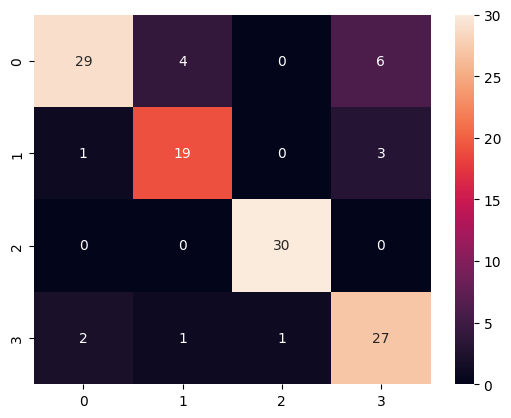

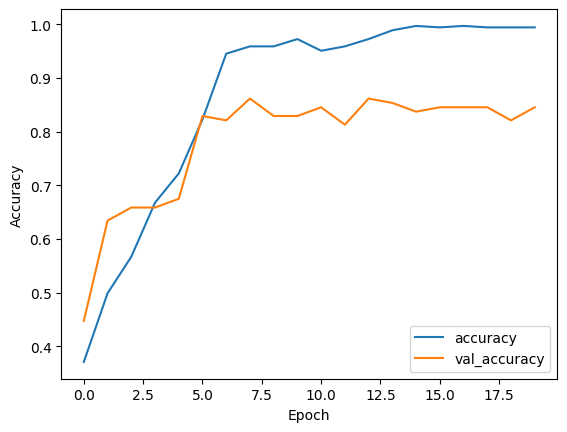

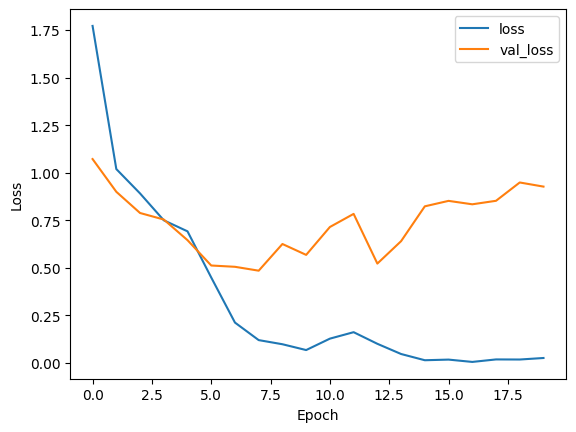

In [21]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import resnet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Flatten, Reshape, Conv2D
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ... (load_and_preprocess_data, split_data, create_hybrid_model functions from previous steps) ...

data_dir = '/content/data/Data/train'
images, labels = load_and_preprocess_data(data_dir)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(images, labels)

input_shape = X_train.shape[1:]
num_classes = len(np.unique(labels))
model = create_hybrid_model(input_shape, num_classes)
model.summary()

# Model Compilation
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Training
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Model Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Performance Metrics
print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

# Training History Visualization
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Save the Model
model.save('lung_cancer_model.h5')

Saving 2 - Copy (3).png to 2 - Copy (3).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


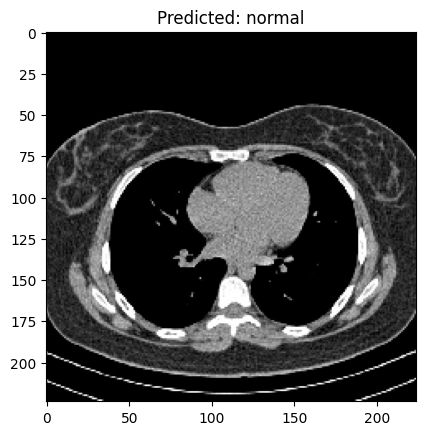

Prediction probabilities: [[2.0507214e-05 4.0766543e-05 9.9966729e-01 2.7150949e-04]]


In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import files #for file uploading.

# Load the saved model
model = tf.keras.models.load_model('lung_cancer_model.h5')

# Upload an image file
uploaded = files.upload()

for filename in uploaded.keys():
    # Load and preprocess the image
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) #add batch dimension.
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array) #preprocess for resnet.

    # Make a prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Define class labels (adjust to your model's labels)
    class_labels = {0: 'adenocarcinoma', 1: 'large.cell.carcinoma', 2: 'normal', 3: 'small.cell.carcinoma'}

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f'Predicted: {class_labels[predicted_class]}')
    plt.show()

    print(f"Prediction probabilities: {predictions}") #print the probabilities.